## Méthode : Particle Filter (PF)

Ce notebook présente l'utilisation du fichier `pf.py` pour assimiler des données


In [1]:
from PfWoFost import PfWoFoSt
import numpy as np
import datetime as dt
import pandas as pd
import pcse
from pcse.models import Wofost72_WLP_FD

from dataloader import Dataloader
import os

from pcse.base import ParameterProvider
from utils import *

# 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.
Dans cet exemple, on va essayer de simuler le champ de notre client

In [2]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [3]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.210785,22.854223
2022-10-03,1.989233,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.233511,23.990529
2022-10-04,1.993524,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.231742,23.902066
2022-10-05,1.998490,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.230323,23.831142
2022-10-06,2.000000,0.0,15561.13719,12050.586227,1857.265611,1653.285351,1441.889672,0.0,50.0,0.229986,23.814270


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

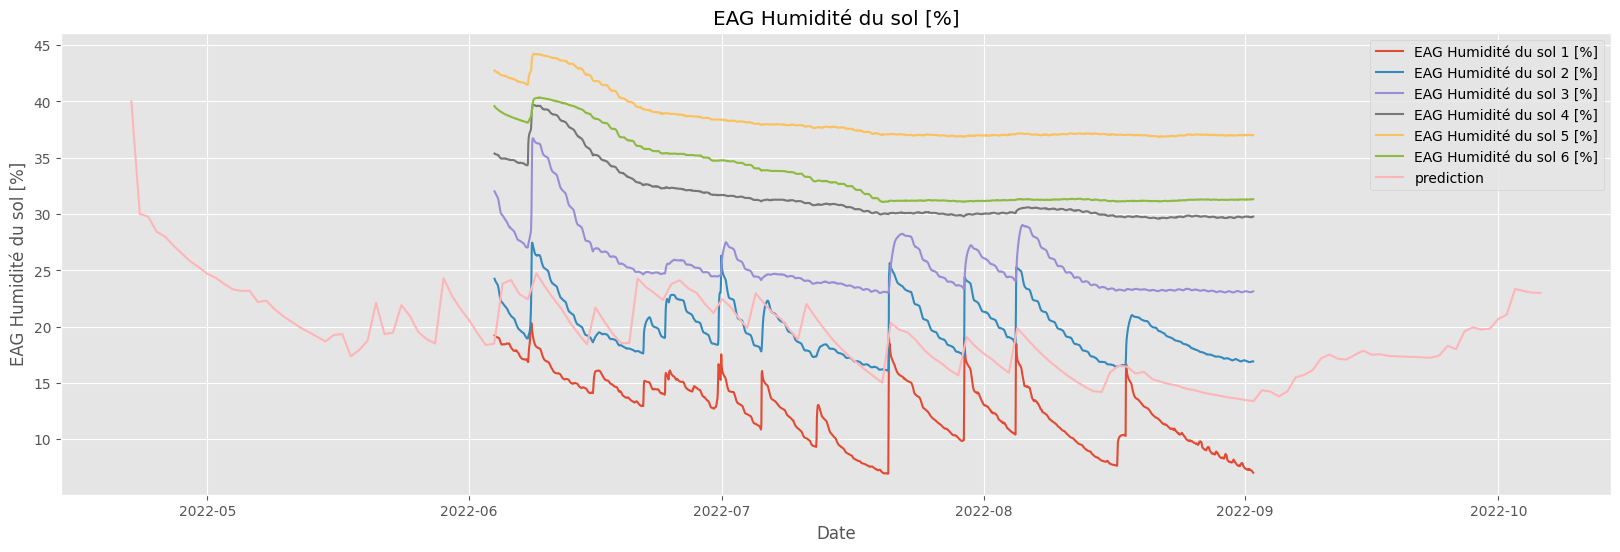

In [4]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

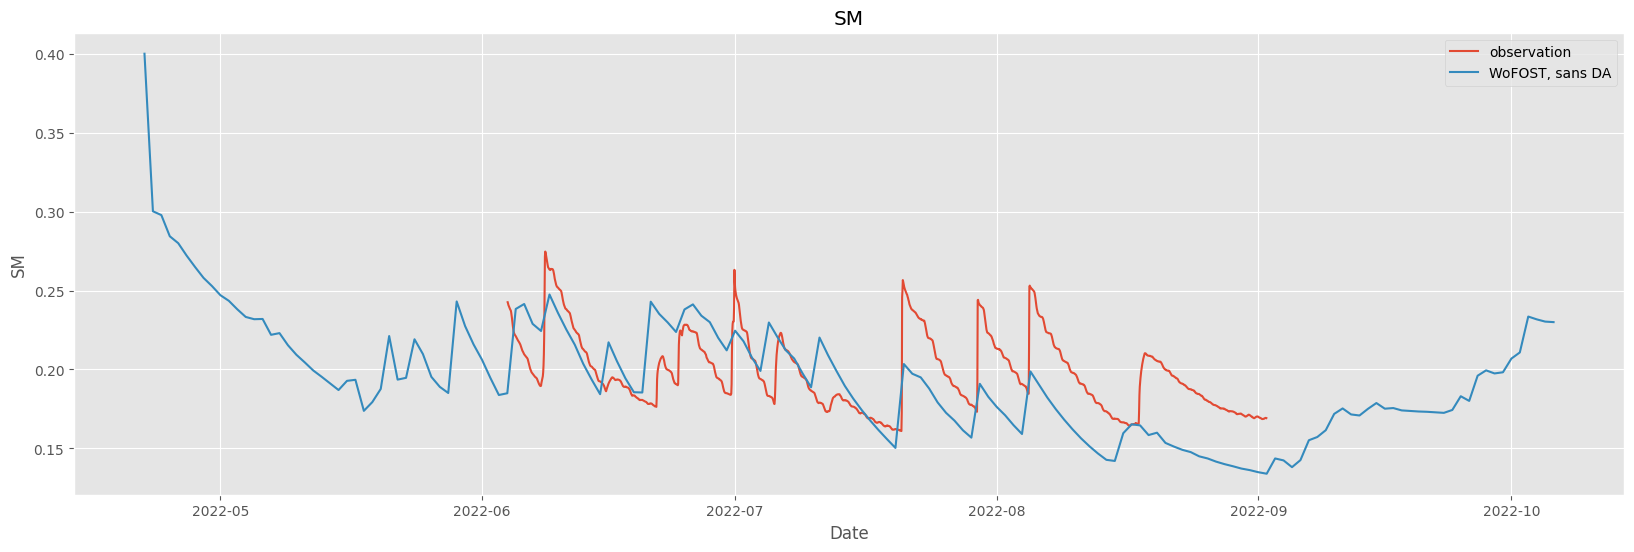

In [5]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

range1=(150.,50.)
range2=(4.5,1.5)
range3=(31,3)
range4=(0.31,0.03)

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

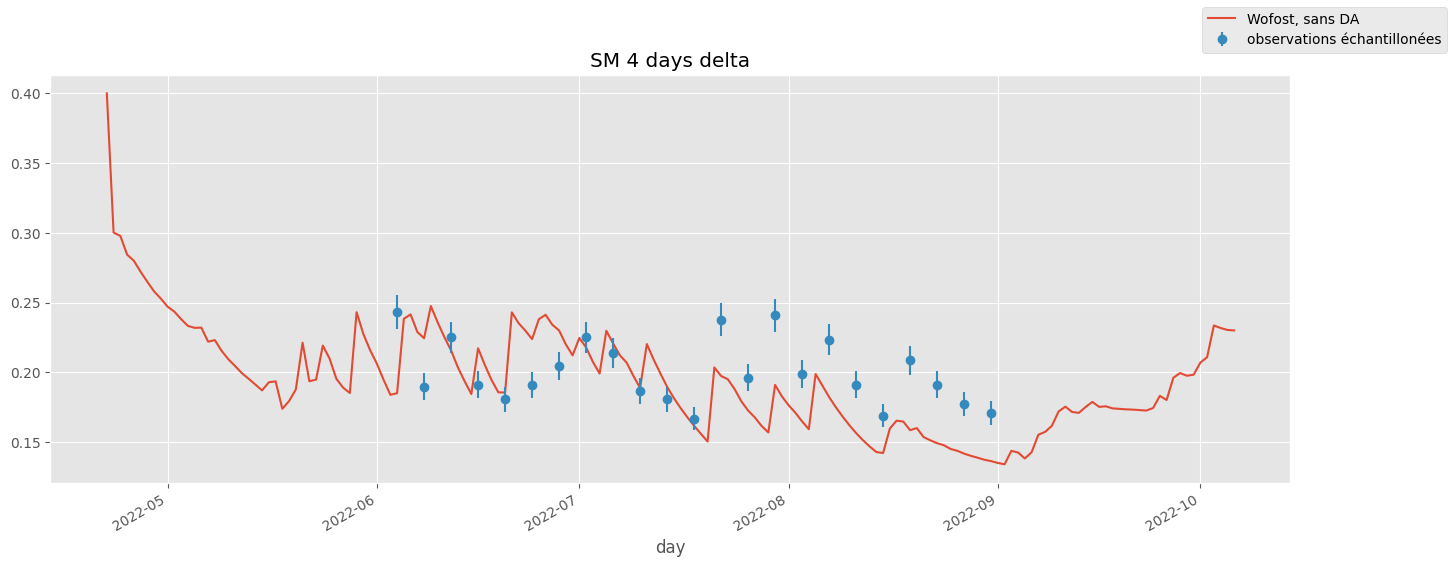

In [6]:
NB_DAYS_DELTA = 4
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]


## 4 - PF

On peut maintenant utiliser le PF. Commençons par spécifier les paramètres sur lesquels nous avons un doute.


=====[Assimilate] Currently on observation 1/23 with 100 particles
Date 2022-06-04 00:00:00, values:{'SM': (0.24350000000000002, 0.012175000000000002)}
[Assimilate] Updated weights. Current SM estimate:  (0.3881743659533294, 0.001290685744244946)

=====[Assimilate] Currently on observation 2/23 with 100 particles
Date 2022-06-08 00:00:00, values:{'SM': (0.18969999999999998, 0.009485)}
[Assimilate] Updated weights. Current SM estimate:  (0.38788028506697875, 0.001226607955630545)

=====[Assimilate] Currently on observation 3/23 with 100 particles
Date 2022-06-12 00:00:00, values:{'SM': (0.225, 0.011250000000000001)}
[Assimilate] Updated weights. Current SM estimate:  (0.38721166850843836, 0.0013301160267531623)

=====[Assimilate] Currently on observation 4/23 with 100 particles
Date 2022-06-16 00:00:00, values:{'SM': (0.1911, 0.009555000000000001)}
[Assimilate] Updated weights. Current SM estimate:  (0.38655837017543043, 0.0013812509001214122)

=====[Assimilate] Currently on observatio

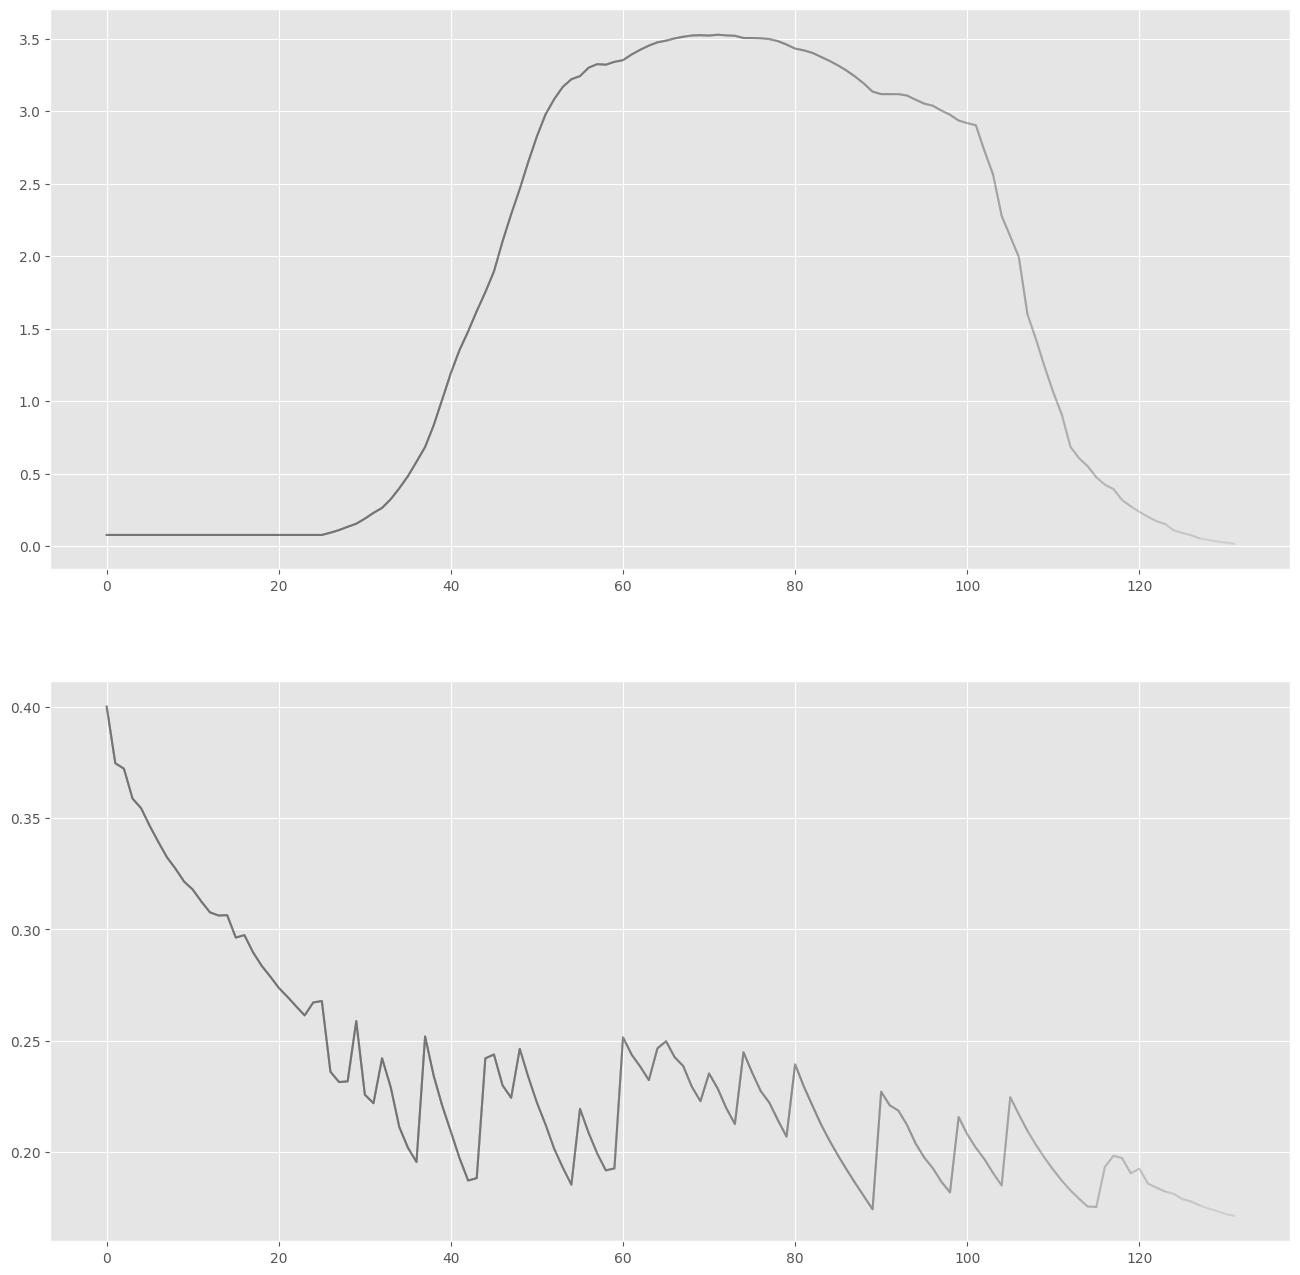

In [7]:

# Appelons maintenant le filtre particulaire
N   = 100
pf  = PfWoFoSt(ensemble_size=N,
              override_parameters=("TDWI","WAV","SPAN","SMFCF"),
              override_ranges=(range1,range2,range3,range4),
              parameters=parameters, weather=weatherd, agromanagement=agrod)
start_date = pf.get_current_date()
pf.get_particles_last_value()
pf.batchAssimilate(observations_for_DA)

Comparons avec les données observées :

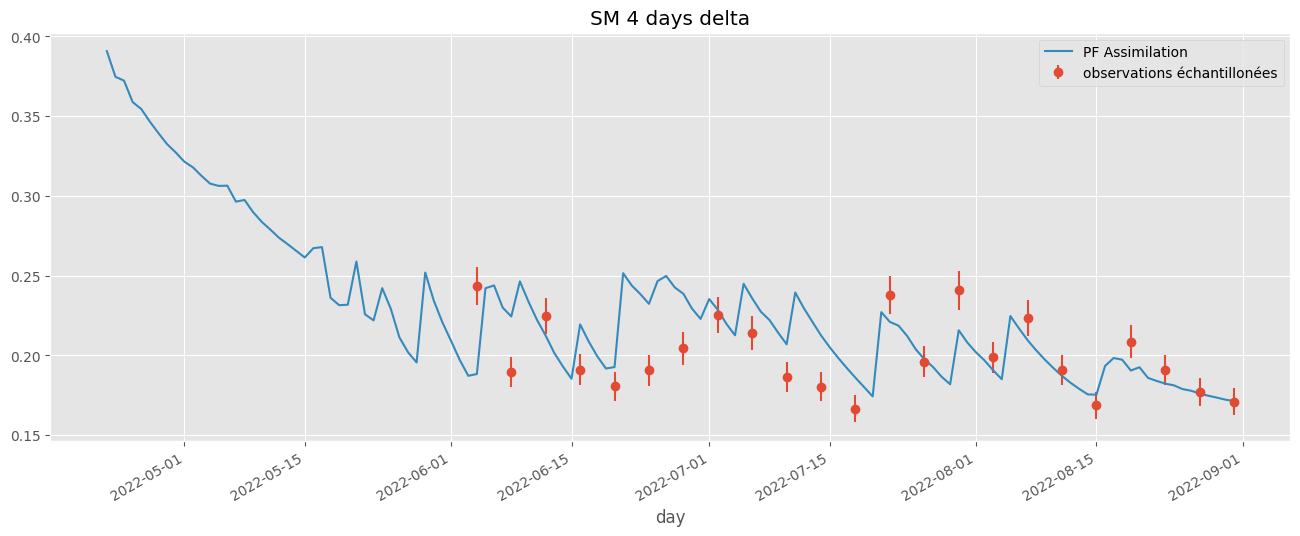

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
results = pf.get_df()
results.plot(y='SM',ax=axes,label='PF Assimilation')
axes.set_title("SM "+ str(NB_DAYS_DELTA) +" days delta")
axes.legend()
fig.autofmt_xdate()


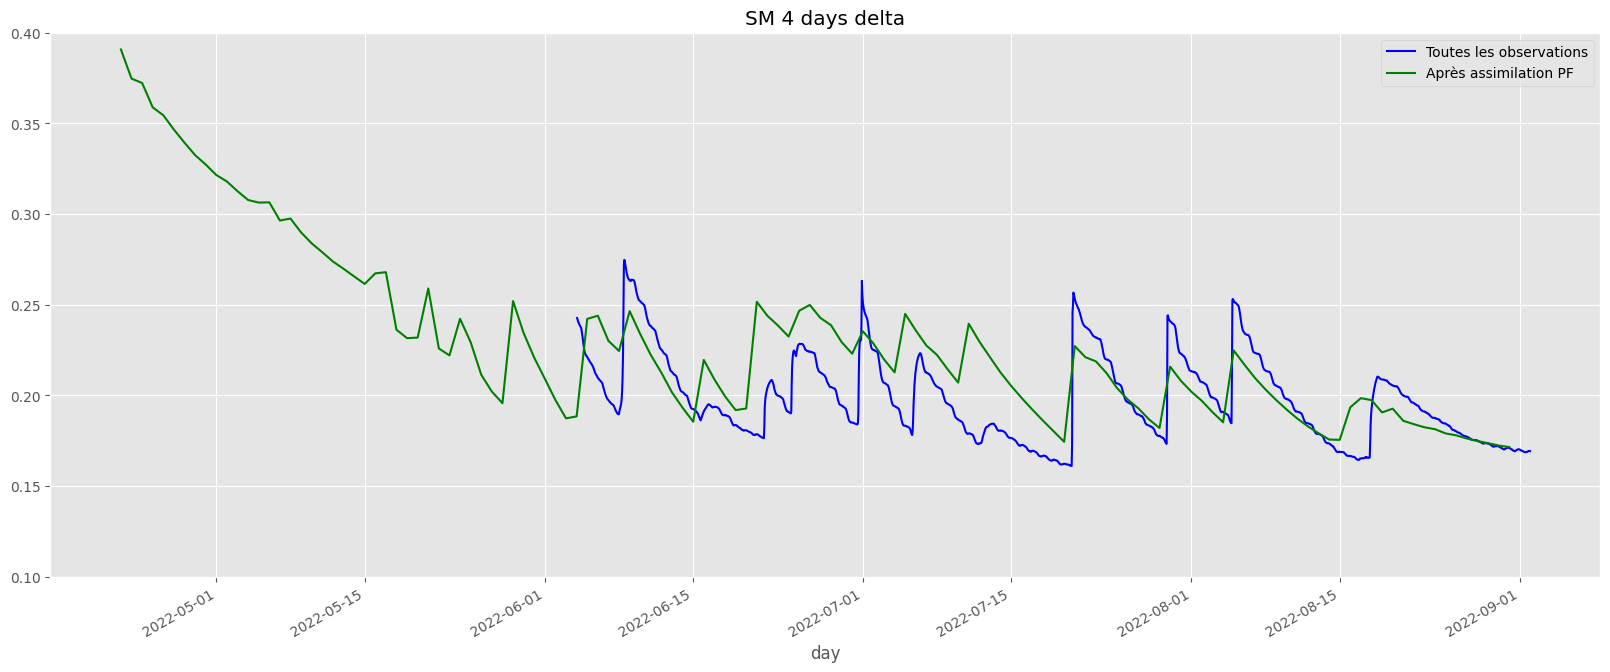

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

axes.plot(df_obs['Date/heure'], df_obs["SM"], label="Toutes les observations", color='b')

#df_enkf_NODA['SM'].plot(ax=axes, label="Before DA", color='r')
results['SM'].plot(ax=axes, label="Après assimilation PF", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

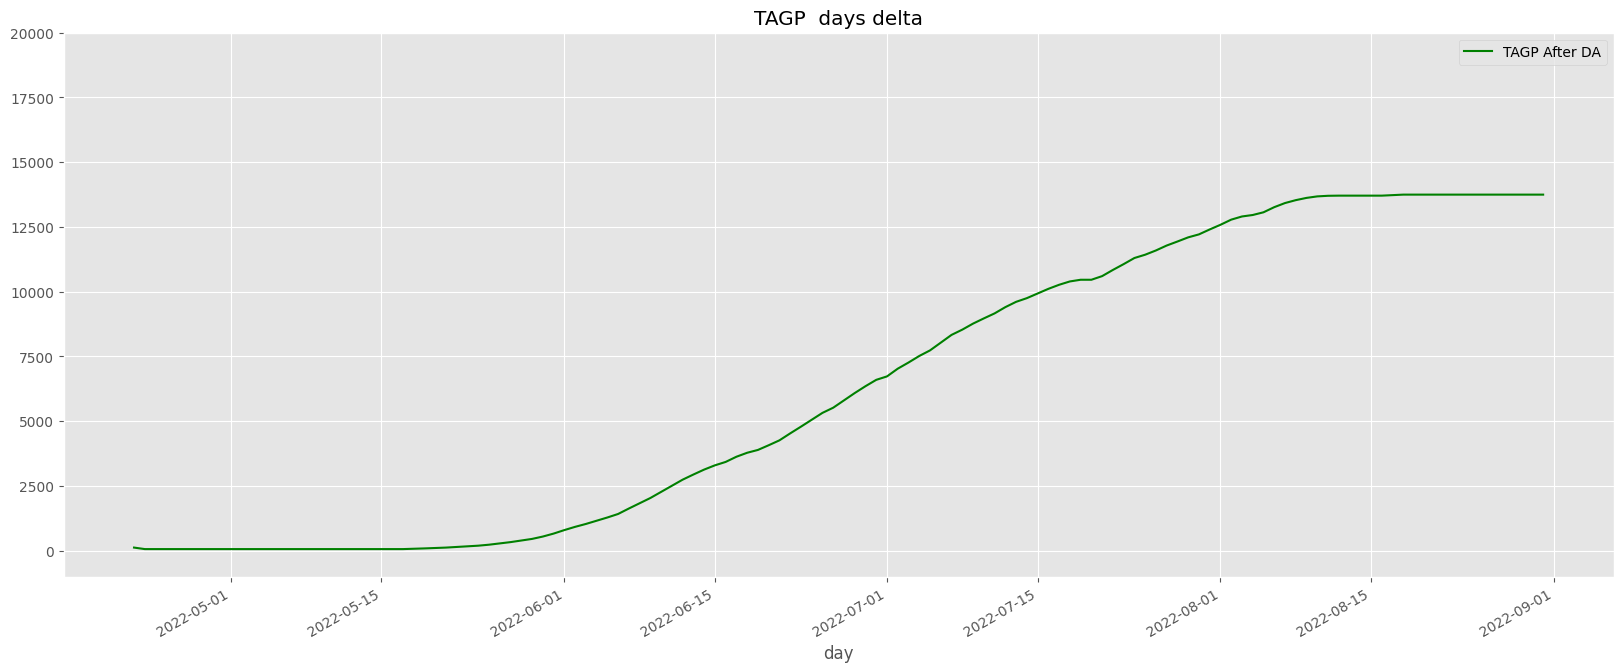

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

results['TAGP'].plot(ax=axes, label="TAGP After DA", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("TAGP "+str( )+" days delta")
axes.set_ylim([-1000, 20000])
fig.autofmt_xdate()

axes.legend()